In [2]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

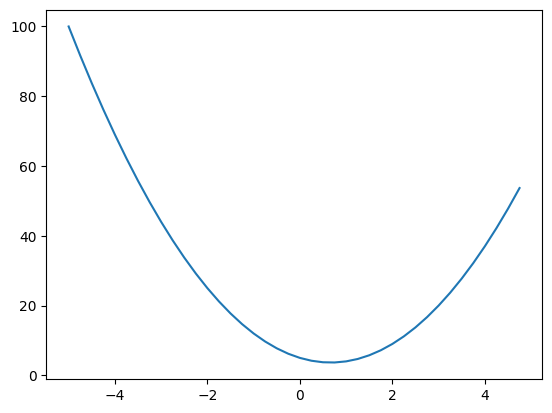

In [16]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [18]:
h = 0.001
x = 3.0
# f(x + h) shows how much the y intercept will change if we nudge the x value by a small h, aka the strength of the slope
# f(x + h) - f(x) this is how much the function responded
(f(x + h) - f(x)) / h # gives the slope, aka direction

14.00300000000243

In [19]:
# Advance

# inputs
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [22]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)

# find out the direction of slope
print((d2 - d1)/h)

d1 4.0
d2 3.999699999999999
-3.000000000010772


In [23]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)

# find out the direction of slope
print((d2 - d1)/h)

d1 4.0
d2 4.0002
2.0000000000042206


In [25]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)

# find out the direction of slope
print((d2 - d1)/h)

d1 4.0
d2 4.0001
0.9999999999976694


In [165]:
# Building Blocks

# Create a value object

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # Handle scalar addition
    out = Value(self.data + other.data, _children=(self, other), _op='+')

    def _backward():
      self.grad += 1.0 * out.grad # Corrected: Accumulate gradient
      other.grad += 1.0 * out.grad # Corrected: Accumulate gradient

    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other) # Handle scalar multiplication
    out = Value(self.data * other.data, _children=(self, other), _op='*')

    def _backward():
      self.grad += other.data * out.grad # Corrected: Accumulate gradient
      other.grad += self.data * out.grad # Corrected: Accumulate gradient
    out._backward = _backward

    return out

  def __radd__(self, other): # other + self
    return self + other

  def __rmul__(self, other): # other * self
    return self * other

  def __sub__(self, other): # self - other
    other = other if isinstance(other, Value) else Value(other)
    out = self + (-other)
    return out

  def __neg__(self):
    return self * -1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, _children=(self,), _op=f'**{other}')

    def _backward():
        self.grad += other * (self.data**(other-1)) * out.grad # Corrected: Accumulate gradient
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, _children=(self,), _op='tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad # Corrected: Accumulate gradient
    out._backward = _backward
    return out



  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

L = d*f; L.label = 'L'

In [13]:
# Visualization

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

# trace(d)

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR: left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
    if n._op:
      # if this value was a result of some operation create an operation node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

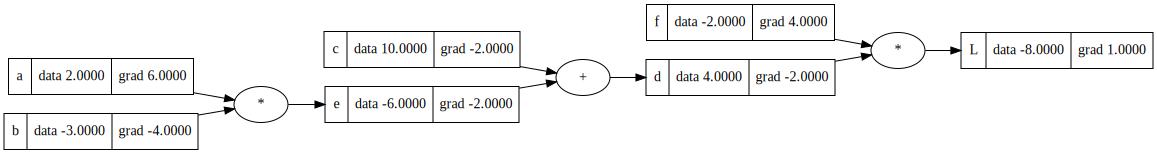

In [172]:
draw_dot(L) # forward pass

In [ ]:
# L = d * f
# dL/dd = f
# df/dd = d
# de/da = d(a*b)/da = b
# de/db = d(a*b)/da = a

# dL/dc

# dd/dc ?

# d = c + e
# dd/dc = d(c+e)/dc = 1.0
# dd/de = 1.0

#chain rule
# dL/dc = (dL/dd) * (dd/de) = f = -2.00
# dL/de = f

# dL/da = (dL/de) * (de/da) = f * b
# dL/db = (dL/de) * (de/db) = f * a


In [171]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data

c.grad = f.data
e.grad = f.data

a.grad = f.data * b.data
b.grad = f.data * a.data

In [96]:
# Example with a small learning rate (kinda optimizationg)

# a.data += 0.01 * a.grad
# b.data += 0.01 * b.grad
# c.data += 0.01 * c.grad
# f.data += 0.01 * f.grad

# e = a*b
# d = e + c
# L = d*f

# print(L.data)

-7.286496


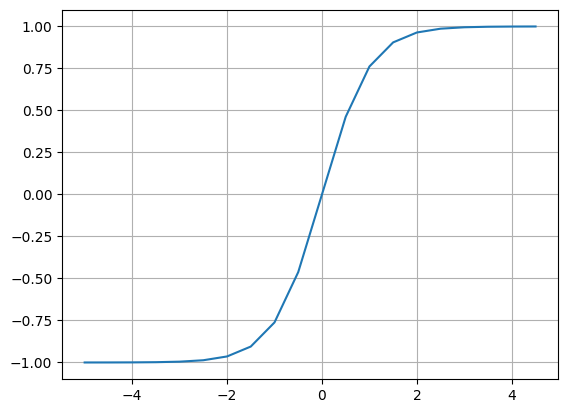

In [102]:
plt.plot(np.arange(-5, 5, 0.5), np.tanh(np.arange(-5, 5, 0.5)));
plt.grid();

In [211]:
# buidling out a neural network from scratch

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of a neuron
b = Value(6.8812725870195432, label='b')

# weighted sum
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

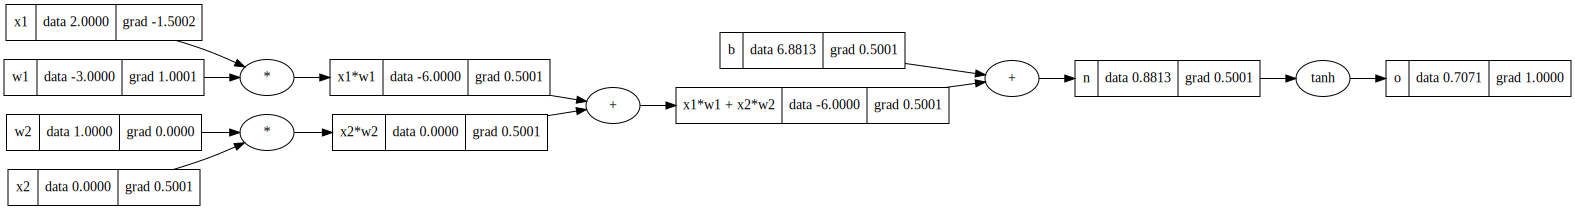

In [216]:
draw_dot(o)

In [181]:
# # o = tanh(n)
# # do/dn = 1 - tanh(n)**2 = 1 - o**2

# o.grad = 1.0
# n.grad = 1 - o.data**2

# x1w1x2w2.grad = n.grad
# b.grad = n.grad

# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data

# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data

In [193]:
o.grad = 1.0

In [215]:
o.backward()

In [200]:
# n._backward()

In [204]:
# b._backward()

In [206]:
# x1w1x2w2._backward()

In [208]:
# x2w2._backward()
# x1w1._backward()

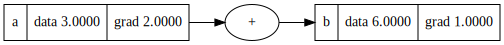

In [219]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()

draw_dot(b)


# explain the bug, cause, the solution (multivariate generalization of chainrule)

In [6]:
# Micrograd implementation in pytorch

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [67]:
# Building out a neural network (MLP) from scratch

import random
import math

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [167]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
o = n(x)
o

Value(data=-0.3151411286651841)

In [69]:
n.parameters()

[Value(data=0.1799434033784464),
 Value(data=0.49055252329460575),
 Value(data=0.15692304171517946),
 Value(data=0.6500488379380536),
 Value(data=0.47471455948630514),
 Value(data=-0.41093482272634363),
 Value(data=0.7723923453324857),
 Value(data=-0.786743259770138),
 Value(data=0.026292290002533747),
 Value(data=0.5450518845866614),
 Value(data=0.9834528533295257),
 Value(data=-0.4645363044522224),
 Value(data=-0.6441126793433205),
 Value(data=-0.07899818371488654),
 Value(data=0.13395117089245367),
 Value(data=-0.8556798456052155),
 Value(data=0.8099631941104786),
 Value(data=-0.016488262486717753),
 Value(data=-0.2743348813718687),
 Value(data=0.612709259037983),
 Value(data=-0.5669771563876123),
 Value(data=-0.1973413998842477),
 Value(data=0.5531721383615291),
 Value(data=0.5151340962902953),
 Value(data=0.40584589140505734),
 Value(data=0.048515012671382474),
 Value(data=-0.7240846920435913),
 Value(data=-0.1903125088207689),
 Value(data=-0.9671944587622188),
 Value(data=0.11895

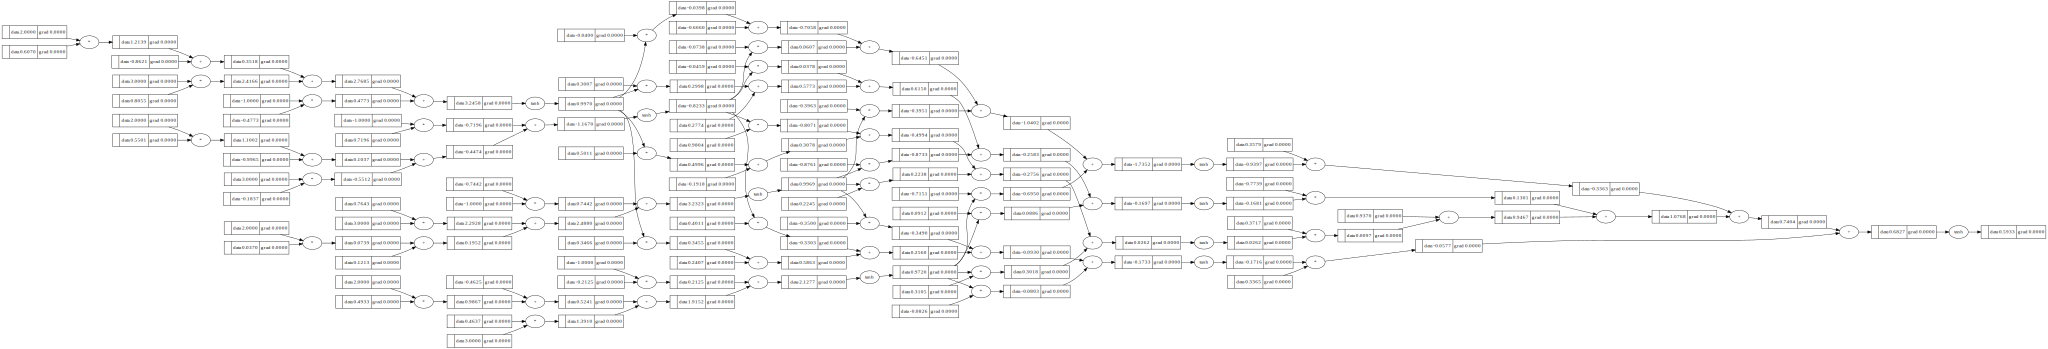

In [48]:
draw_dot(o)

In [180]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6328722828512846)

In [181]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [182]:
for k in range(100):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update the gradient
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 6.147733293686995
1 3.8495140668930516
2 2.7728506924736616
3 2.170140762266167
4 1.6732367787864786
5 1.1645700422465408
6 0.7228172902490821
7 0.46085572293290455
8 0.320117870278864
9 0.24107784947470665
10 0.19148876675693838
11 0.15793241529357643
12 0.13391188708613747
13 0.11595682321710626
14 0.10207242020301413
15 0.09104035096308122
16 0.08207846406072405
17 0.07466343991278138
18 0.06843280342385541
19 0.06312801464339546
20 0.05855997558473362
21 0.0545873404421438
22 0.051102434157934445
23 0.048021851397764326
24 0.04528002373164243
25 0.042824720583827414
26 0.04061384062020111
27 0.03861308298007536
28 0.036794230130743746
29 0.035133863406978744
30 0.03361238956376456
31 0.0322132941600135
32 0.030922562596451025
33 0.029728226597467204
34 0.028620005621558687
35 0.027589020863993452
36 0.026627565312896853
37 0.02572891748106077
38 0.0248871894572016
39 0.024097202138168995
40 0.023354382148047453
41 0.022654676181035782
42 0.02199447943465036
43 0.02137057550781686

In [183]:
ypred

[Value(data=0.9579429998213508),
 Value(data=-0.9664581650563081),
 Value(data=-0.94929203328663),
 Value(data=0.9488032013607951)]